### CMPE 252 : Artificial Intelligence and Data Engineering [Spring 2023]
### Home Assignment 2
### Probabilistic Reasoning in Dynamical Systems - Kalman Filter


In [60]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [61]:
# Initialise variable values

A = np.array([[0.99951, 0.00999837], [-0.09784, 0.99951]])
C = np.array([0,1])

mu_mean = np.array([0, 0])
mu_cov = np.array([[1.00207*10**(-7), 4.31094*10**(-8)], [4.31094*10**(-8), 9.6011*10**(-6)]])

v_mean = 0
v_var = 0.01

x0 = np.array([0.1, 0.0]) # initial state


In [62]:
#Dynamics Model
dynamics = lambda x: np.matmul(A, x) + np.random.multivariate_normal(mu_mean, mu_cov, 1)

#Measurement Model
observation = lambda x: np.matmul(C, x) + np.random.normal(v_mean, v_var)

### Question 1
Starting from x[0] = [0.1;0.0], simulate the pendulum
dynamics for T = 499 steps, where mu[k] is sampled from the
two dimensional Gaussian with the mean mu_mean, and the
covariance mu_cov, and v[k] is sampled from the one dimensional
Gaussian with the mean v_mean, and variance, v_var.

The simulated state and observation trajectories are arrays
with dimensions 2 x 500 and 1 x 500, respectively. (In practice, the true state is unknown.)

In [65]:
def simulate_pendulum_dynamics(T, x0):

  sim_state = np.empty((2,T))
  obs_trajectory = np.empty((1,T))

  x = x0
  for i in range(T):

    x1 = dynamics(x)
    y = observation(x)

    x1 = np.transpose(x1).reshape((2,))
    #print(i, x1, y)
    
    sim_state[0][i], sim_state[1][i] = x1[0], x1[1]
    obs_trajectory[0][i] = y

    x = x1 # assign next state as current state

  return sim_state, obs_trajectory

T = 499
time = range(1,T+1)

simulated_state, obs_trajectory = simulate_pendulum_dynamics(T, x0)


### Question 2
Plot the following on the same figure as a function of time. Add the legend.
*   the true angle x[1:], 
*   true angular velocity x[2:], and
*   the measured noisy angular velocity y[:]


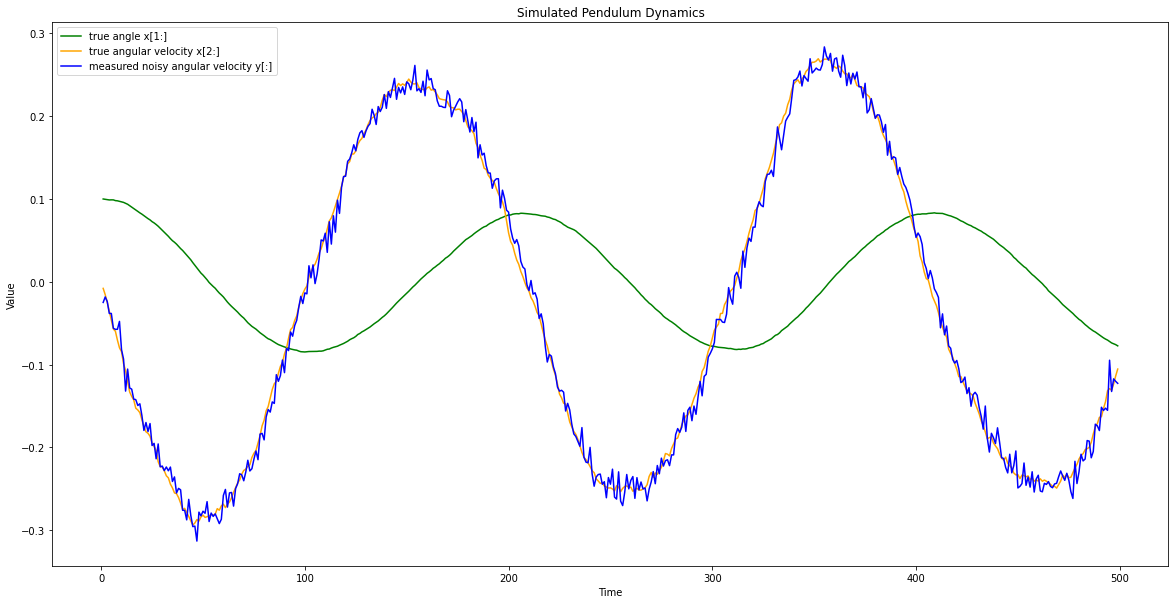

In [66]:
plt.plot(time, simulated_state[0][:], color = "green", label="true angle x[1:]")
plt.plot(time, simulated_state[1][:], color = "orange", label="true angular velocity x[2:]")
plt.plot(time, obs_trajectory[0][:], color = "blue", label="measured noisy angular velocity y[:]")

plt.rcParams['figure.figsize'] = [20, 10]
plt.legend(loc="upper left")
plt.title("Simulated Pendulum Dynamics")
plt.xlabel("Time")
plt.ylabel("Value")

plt.show()

### Question 3
State reconstruction by Kalman filter:



#### Question 3.1

*   Calculate recursively the state estimation covariance matrix,
Σt+1|t, for t € [1,500]. 
Assume Σ0|-1 = 1e-3 * IdentityMartrix_2x2.
*   See Slide 8-18 at https://stanford.edu/class/ee363/lectures/kf.pdf

In [67]:
# Riccati Recursion
next_state_cov = lambda sigma_t : A.dot(sigma_t).dot(np.transpose(A)) + mu_cov # Σt+1|t = AΣt|t−1AT + W

In [68]:
def state_estimation_covariance(sigma_zero):

  state_estimation_cov_mat = np.empty((T+1, 2, 2))

  sigma_t = sigma_zero
  state_estimation_cov_mat[0][0][0], state_estimation_cov_mat[0][0][1] = sigma_t[0][0], sigma_t[0][1]
  state_estimation_cov_mat[0][1][0], state_estimation_cov_mat[0][1][1] = sigma_t[1][0], sigma_t[1][1]

  for i in range(1, T+1):
    sigma_t1 = next_state_cov(sigma_t)

    state_estimation_cov_mat[i][0][0], state_estimation_cov_mat[i][0][1] = sigma_t1[0][0], sigma_t1[0][1]
    state_estimation_cov_mat[i][1][0], state_estimation_cov_mat[i][1][1] = sigma_t1[1][0], sigma_t1[1][1]

    sigma_t = sigma_t1

  return state_estimation_cov_mat

sigma_zero = 10**(-3) * ( I_2x2 := np.array([[1, 0], [0, 1]]) ) # initial covariance
state_estimation_cov_mat = state_estimation_covariance(sigma_zero)


#### Question 3.2


*   Reconstruct the full state, X^t+1|t, for t € [1,500] from the sensor readings, y[:], only. Assume X^0|-1 = [0.1, 0].
*   See Slide
8-20. (x(1,:] and x[2, :] are unknown /hidden). 


  

In [69]:
# reconstruct_next_state = np.matmul(A, x_t_estimate) + observer_gain(sigma_t)*(y_t - y_t_estimate(x_t_estimate))

def reconstruct_next_state(x_t_estimate, sigma_t, y_measured, y_t_estimate):
  observer_gain = A.dot(sigma_t).dot(np.transpose(C)) * (C.dot(sigma_t).dot(np.transpose(C)) + v_var)**(-1)
  x_t1_estimate = np.matmul(A, x_t_estimate) + observer_gain * (y_measured - y_t_estimate)
  return x_t1_estimate

def full_state_reconstruction(x0, state_estimation_cov_mat):

  x_t_estimate = x0
  
  state_reconstruction_mat = np.empty((2,T+1))
  state_reconstruction_mat[0][0], state_reconstruction_mat[1][0] = x_t_estimate[0], x_t_estimate[1]

  reconstructed_y = np.empty((1,T))
  for i in range(1, T+1) :

    y_t_estimate = C.dot(x_t_estimate)
    x_t1_estimate = reconstruct_next_state(x_t_estimate, state_estimation_cov_mat[i], obs_trajectory[0][i-1],  y_t_estimate)

    state_reconstruction_mat[0][i], state_reconstruction_mat[1][i] = x_t1_estimate[0], x_t1_estimate[1]
    reconstructed_y[0][i-1] = y_t_estimate

    x_t_estimate = x_t1_estimate
  
  return state_reconstruction_mat, reconstructed_y

state_reconstruction_mat, reconstructed_y = full_state_reconstruction(x0, state_estimation_cov_mat)

### Question 4 

*   Add to the previous plot X^t+1|t[1, :], X^t+1|t[2, :], and Y^t+1|t[:].
*   Add legend.
*   Explain your observations.


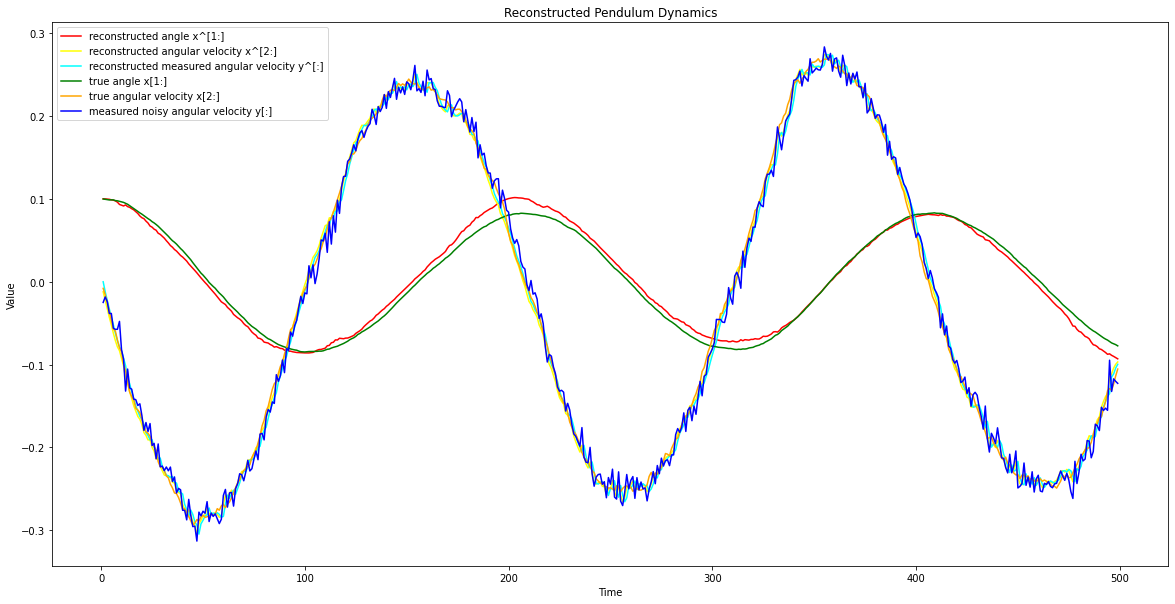

In [70]:
plt.plot(time, state_reconstruction_mat[0][1:], color = "red",label="reconstructed angle x^[1:]")
plt.plot(time, state_reconstruction_mat[1][1:], color = "yellow",label="reconstructed angular velocity x^[2:]")
plt.plot(time, reconstructed_y[0][:], color = "cyan",label="reconstructed measured angular velocity y^[:]")
plt.plot(time, simulated_state[0][:], color = "green", label="true angle x[1:]")
plt.plot(time, simulated_state[1][:], color = "orange", label="true angular velocity x[2:]")
plt.plot(time, obs_trajectory[0][:], color = "blue", label="measured noisy angular velocity y[:]")

plt.rcParams['figure.figsize'] = [20, 10]
plt.legend(loc="upper left")
plt.title("Reconstructed Pendulum Dynamics")
plt.xlabel("Time")
plt.ylabel("Value")

plt.show()

Explain observations here
#
#
#

### Question 5 
 

*   Repeat 10 times the questions 1, 3.1, and 3.2.
*   Plots all the curves on the same plot as a function of time, and 
*   Explain the meaning of the variance of the curves for X^t+1|t[1, :], X^t+1|t[2, :], and Y^t+1|t[:].

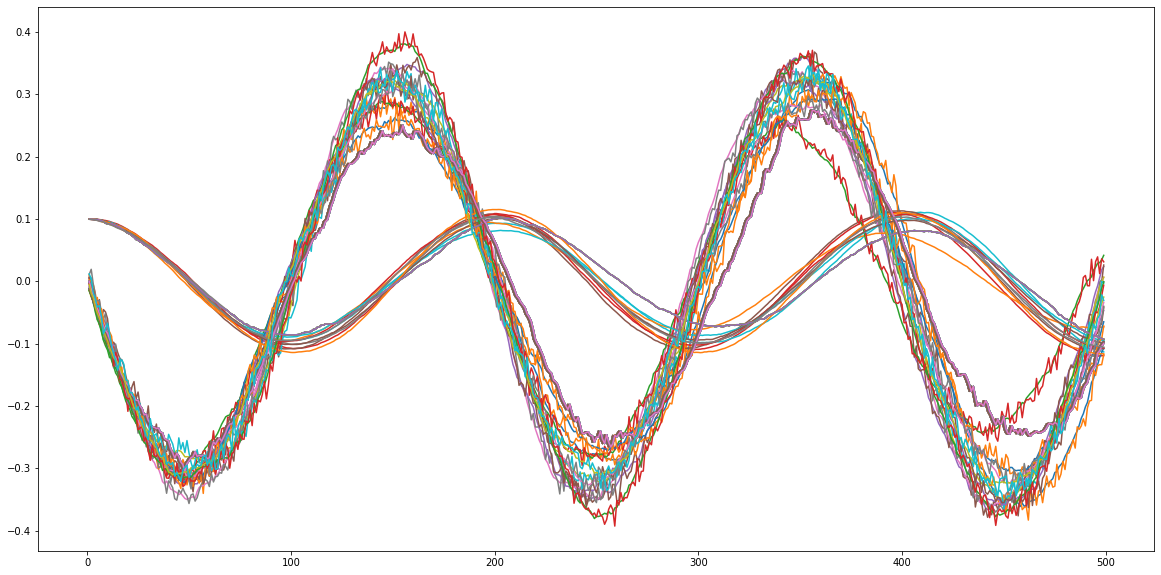

In [71]:
for _ in range(10):

  simulated_state_1, obs_trajectory_1 = simulate_pendulum_dynamics(T, x0) #Q1
  state_estimation_cov_mat_1 = state_estimation_covariance(sigma_zero) #Q3.1
  state_reconstruction_mat_1, reconstructed_y_1 = full_state_reconstruction(x0, state_estimation_cov_mat_1) #Q3.2

  plt.plot(time, state_reconstruction_mat_1[0][1:])
  plt.plot(time, state_reconstruction_mat_1[1][1:])
  plt.plot(time, reconstructed_y_1[0][:])
  plt.plot(time, simulated_state_1[0][:])
  plt.plot(time, simulated_state_1[1][:])
  plt.plot(time, obs_trajectory_1[0][:])

plt.show()

Explain meaning of the variance